## Notes 
### Required installing Oracle JAVA 8 to get javabridge installed
### Then, I was able to install py-causal from https://bd2kccd.github.io/docs/py-causal/
### GFCI is slower than RFCI, but more accurate (SPIRTES), GFCI and RFCI account for unobserved variables, FGES assumes no unobserved variables.

Structure Learning Performance Guarantees If the assumptions in the previous section hold, then in the large sample limit, the CBN structure output by GFCId will contain an edge of one of four kinds between Xand Y   if and only if Xand Yare not independent conditional on any subset of the other measured variables of less than or equal to a specified size. In addition, there is (1) an arc X->Y   if and only if Xdirectly or indirectly causes Y, and Y   does not directly or indirectly cause X; (2) an edge X <-->Y   if and only if X   is not a direct or indirect cause of Yand Y   is not a direct or indirect cause of X(which can only occur if there are latent confounders of Xand some other variable or Yand some other variable; (3) an edge Xo->Y   only if Yis not a direct or indirect cause of X, but Xmay or may not be an indirect cause of Y; (4) an edge X o–o Y   indicates that Xand Y   are dependent no matter what subset of observed variables is conditioned on, but contains no orientation information (X   may be a direct or indirect cause of Y, and Ymay be an indirect cause of X, or there may be a latent common cause of Xand Y.

# Trying some various ML models

In [1]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="0" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))

    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model


/home/tkyono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s




def discrete_gauss(low, high, samples, std = 20):
    x = np.arange(low, high)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.norm.cdf(xU, scale = std) - ss.norm.cdf(xL, scale = std)
    prob = prob / prob.sum() #normalize the probabilities so their sum is 1
    nums = np.random.choice(x, size = samples, p = prob)
    return nums



def bar_plot(x_ax, val1, val1std, val2, val2std):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ## the data
    N = len(x_ax)

    ## necessary variables
    ind = np.arange(N)                # the x locations for the groups
    width = 0.35                      # the width of the bars
    fig.set_size_inches(18.5, 10.5)
    ## the bars
    rects1 = ax.bar(ind, val1, width,
                    color='gray',
                    yerr=val1std,
                    error_kw=dict(elinewidth=2,ecolor='blue'))

    rects2 = ax.bar(ind+width, val2, width,
                        color='blue',
                        #yerr=val2std,
                        error_kw=dict(elinewidth=2,ecolor='gray'))

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    #ax.set_ylim(0,45)
    ax.set_ylabel('Percentage')
    ax.set_title('')
    plt.xticks(ind + width / 2, x_ax, rotation=75, size = 14)
    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('Accuracy', '% Violations') )
    fig.savefig("violations.pdf", bbox_inches='tight')
    plt.show()



def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = 1.1* a + np.random.normal(mean, var, SIZE)
    c =  0.5* b + np.random.normal(mean, var, SIZE)
    
    e = np.random.normal(mean, var, SIZE)
    
    d = e + b + np.random.normal(mean, var, SIZE)
    
    f= b +  d + np.random.normal(mean, var, SIZE)
    g = f + np.random.normal(mean,var, SIZE)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})


def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = a + np.random.normal(mean, var, SIZE)
    c =  a + b + np.random.normal(mean, var, SIZE)
  
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c})


def get_CG(df, tetrad):
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
           structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
           completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    #tetrad.run(algoId = 'fges-mb', targetName = 'g', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
    #       structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
    #       completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)


    return tetrad.getTetradGraph()

def get_MB(graph, var, pc):
    parents = set()
    children = set()
    for i in pc.extractTetradGraphEdges(graph):
        if i[-1] == var and i[3:5] == '->':
            parents.add(i[0])
        if i[0] == var and i[3:5] == '->':
            children.add(i[-1])
    return parents, children

from pycausal.pycausal import pycausal as pc
from collections import defaultdict
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()


verbosity = 1



models = []
model_names = []

num_models = 150

randomize = True
if randomize:
    layers = [256, 512, 1024, 2048, 4096]
    for i in range(num_models):
        network = []
        for j in range(3):
            network.append(layers[random.randint(0,len(layers) -1)])
        models.append(network)
        model_names.append('temp/random' + str(i))
    print(models, model_names)    
else:
    model_layers = [512,256]
    for i in range(num_models):
        models.append(model_layers)
        model_names.append('temp/e' + str(i))

print(models, model_names)

inputs = ['a', 'b']
target = ['c']
df = gen_data()
X = df[inputs].values
y = df[target].values

val_df = gen_data(SIZE = 2000)
x_val = df[inputs].values
y_val = df[target].values



/home/tkyono/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


[[1024, 2048, 4096], [512, 2048, 256], [2048, 1024, 2048], [512, 4096, 512], [4096, 256, 256], [4096, 1024, 512], [256, 256, 256], [256, 4096, 4096], [2048, 4096, 256], [1024, 256, 1024], [2048, 1024, 2048], [1024, 2048, 512], [512, 2048, 1024], [2048, 2048, 1024], [2048, 2048, 4096], [1024, 1024, 2048], [1024, 512, 2048], [1024, 256, 1024], [4096, 2048, 1024], [256, 4096, 512], [1024, 512, 512], [4096, 1024, 1024], [1024, 256, 4096], [1024, 4096, 4096], [2048, 512, 1024], [4096, 2048, 512], [1024, 2048, 2048], [512, 256, 512], [1024, 4096, 4096], [1024, 2048, 1024], [2048, 2048, 1024], [256, 512, 2048], [4096, 1024, 2048], [4096, 256, 4096], [512, 256, 2048], [512, 512, 2048], [1024, 256, 2048], [256, 1024, 1024], [256, 1024, 256], [2048, 1024, 4096], [4096, 4096, 4096], [4096, 2048, 512], [4096, 512, 4096], [512, 2048, 512], [512, 2048, 2048], [512, 2048, 1024], [256, 512, 2048], [4096, 4096, 256], [4096, 2048, 4096], [2048, 1024, 2048], [512, 1024, 1024], [512, 4096, 256], [2048, 10

In [3]:
for idx, model_name in enumerate(model_names):
    print(model_name)

    if type(models[idx]) is list:
        #clear session
        keras.backend.clear_session() 
        #get model according to specification
        model = get_model(models[idx], [0.2] * len(models), len(inputs))
        callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                     EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
        model.compile(optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
        #print(len(X), len(y))
        model.fit(X, y, epochs = 20, validation_data = (x_val, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
    else:
        models[idx].fit(X,y)


temp/random0
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 5s 233us/step - loss: 1.1968 - mean_squared_error: 1.1968 - val_loss: 1.0218 - val_mean_squared_error: 1.0218

Epoch 00001: val_loss improved from inf to 1.02180, saving model to temp/random0
Epoch 2/20
20000/20000 [==============================] - 4s 180us/step - loss: 1.0278 - mean_squared_error: 1.0278 - val_loss: 1.0261 - val_mean_squared_error: 1.0261

Epoch 00002: val_loss did not improve from 1.02180
Epoch 3/20
20000/20000 [==============================] - 4s 178us/step - loss: 1.0261 - mean_squared_error: 1.0261 - val_loss: 1.0239 - val_mean_squared_error: 1.0239

Epoch 00003: val_loss did not improve from 1.02180
Epoch 00003: early stopping
temp/random1
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 136us/step - loss: 1.1979 - mean_squared_error: 1.1979 - val_loss: 1.0620 - val_mean_squared_er

20000/20000 [==============================] - 3s 132us/step - loss: 1.0877 - mean_squared_error: 1.0877 - val_loss: 1.0893 - val_mean_squared_error: 1.0893

Epoch 00002: val_loss improved from 1.10313 to 1.08929, saving model to temp/random6
Epoch 3/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0739 - mean_squared_error: 1.0739 - val_loss: 1.0749 - val_mean_squared_error: 1.0749

Epoch 00003: val_loss improved from 1.08929 to 1.07494, saving model to temp/random6
Epoch 4/20
20000/20000 [==============================] - 3s 135us/step - loss: 1.0706 - mean_squared_error: 1.0706 - val_loss: 1.0749 - val_mean_squared_error: 1.0749

Epoch 00004: val_loss improved from 1.07494 to 1.07492, saving model to temp/random6
Epoch 5/20
20000/20000 [==============================] - 3s 133us/step - loss: 1.0656 - mean_squared_error: 1.0656 - val_loss: 1.0690 - val_mean_squared_error: 1.0690

Epoch 00005: val_loss improved from 1.07492 to 1.06897, saving model to temp/ran


Epoch 00003: val_loss did not improve from 1.02510
Epoch 4/20
20000/20000 [==============================] - 2s 124us/step - loss: 1.0356 - mean_squared_error: 1.0356 - val_loss: 1.0249 - val_mean_squared_error: 1.0249

Epoch 00004: val_loss improved from 1.02510 to 1.02488, saving model to temp/random10
Epoch 5/20
20000/20000 [==============================] - 3s 125us/step - loss: 1.0237 - mean_squared_error: 1.0237 - val_loss: 1.0267 - val_mean_squared_error: 1.0267

Epoch 00005: val_loss did not improve from 1.02488
Epoch 6/20
20000/20000 [==============================] - 3s 125us/step - loss: 1.0329 - mean_squared_error: 1.0329 - val_loss: 1.0308 - val_mean_squared_error: 1.0308

Epoch 00006: val_loss did not improve from 1.02488
Epoch 00006: early stopping
temp/random11
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.1994 - mean_squared_error: 1.1994 - val_loss: 1.0376 - val_mean_squared_error: 

Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.2761 - mean_squared_error: 1.2761 - val_loss: 1.0766 - val_mean_squared_error: 1.0766

Epoch 00001: val_loss improved from inf to 1.07656, saving model to temp/random17
Epoch 2/20
20000/20000 [==============================] - 2s 123us/step - loss: 1.0630 - mean_squared_error: 1.0630 - val_loss: 1.1005 - val_mean_squared_error: 1.1005

Epoch 00002: val_loss did not improve from 1.07656
Epoch 3/20
20000/20000 [==============================] - 2s 116us/step - loss: 1.0542 - mean_squared_error: 1.0542 - val_loss: 1.0573 - val_mean_squared_error: 1.0573

Epoch 00003: val_loss improved from 1.07656 to 1.05733, saving model to temp/random17
Epoch 4/20
20000/20000 [==============================] - 2s 120us/step - loss: 1.0501 - mean_squared_error: 1.0501 - val_loss: 1.0762 - val_mean_squared_error: 1.0762

Epoch 00004: val_loss did not improve from 1.05733
Epoc


Epoch 00002: val_loss did not improve from 1.03187
Epoch 3/20
20000/20000 [==============================] - 3s 138us/step - loss: 1.0336 - mean_squared_error: 1.0336 - val_loss: 1.0503 - val_mean_squared_error: 1.0503

Epoch 00003: val_loss did not improve from 1.03187
Epoch 00003: early stopping
temp/random22
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.3254 - mean_squared_error: 1.3254 - val_loss: 1.0546 - val_mean_squared_error: 1.0546

Epoch 00001: val_loss improved from inf to 1.05460, saving model to temp/random22
Epoch 2/20
20000/20000 [==============================] - 2s 119us/step - loss: 1.0533 - mean_squared_error: 1.0533 - val_loss: 1.0392 - val_mean_squared_error: 1.0392

Epoch 00002: val_loss improved from 1.05460 to 1.03922, saving model to temp/random22
Epoch 3/20
20000/20000 [==============================] - 2s 123us/step - loss: 1.0477 - mean_squared_error: 1.0477 - val_loss: 1.


Epoch 00004: val_loss did not improve from 1.05175
Epoch 5/20
20000/20000 [==============================] - 2s 121us/step - loss: 1.0516 - mean_squared_error: 1.0516 - val_loss: 1.0747 - val_mean_squared_error: 1.0747

Epoch 00005: val_loss did not improve from 1.05175
Epoch 00005: early stopping
temp/random28
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 5s 254us/step - loss: 1.1807 - mean_squared_error: 1.1807 - val_loss: 1.0321 - val_mean_squared_error: 1.0321

Epoch 00001: val_loss improved from inf to 1.03215, saving model to temp/random28
Epoch 2/20
20000/20000 [==============================] - 4s 222us/step - loss: 1.0247 - mean_squared_error: 1.0247 - val_loss: 1.0226 - val_mean_squared_error: 1.0226

Epoch 00002: val_loss improved from 1.03215 to 1.02262, saving model to temp/random28
Epoch 3/20
20000/20000 [==============================] - 4s 220us/step - loss: 1.0246 - mean_squared_error: 1.0246 - val_loss: 1.

20000/20000 [==============================] - 3s 134us/step - loss: 1.0256 - mean_squared_error: 1.0256 - val_loss: 1.0160 - val_mean_squared_error: 1.0160

Epoch 00009: val_loss improved from 1.02169 to 1.01599, saving model to temp/random32
Epoch 10/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.0284 - mean_squared_error: 1.0284 - val_loss: 1.0200 - val_mean_squared_error: 1.0200

Epoch 00010: val_loss did not improve from 1.01599
Epoch 11/20
20000/20000 [==============================] - 3s 133us/step - loss: 1.0273 - mean_squared_error: 1.0273 - val_loss: 1.0195 - val_mean_squared_error: 1.0195

Epoch 00011: val_loss did not improve from 1.01599
Epoch 00011: early stopping
temp/random33
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 126us/step - loss: 1.3763 - mean_squared_error: 1.3763 - val_loss: 1.0423 - val_mean_squared_error: 1.0423

Epoch 00001: val_loss improved from inf to 1.04234, s

20000/20000 [==============================] - 2s 114us/step - loss: 1.0515 - mean_squared_error: 1.0515 - val_loss: 1.0492 - val_mean_squared_error: 1.0492

Epoch 00002: val_loss improved from 1.05467 to 1.04916, saving model to temp/random37
Epoch 3/20
20000/20000 [==============================] - 2s 115us/step - loss: 1.0497 - mean_squared_error: 1.0497 - val_loss: 1.0521 - val_mean_squared_error: 1.0521

Epoch 00003: val_loss did not improve from 1.04916
Epoch 4/20
20000/20000 [==============================] - 2s 114us/step - loss: 1.0424 - mean_squared_error: 1.0424 - val_loss: 1.0572 - val_mean_squared_error: 1.0572

Epoch 00004: val_loss did not improve from 1.04916
Epoch 00004: early stopping
temp/random38
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 124us/step - loss: 1.2390 - mean_squared_error: 1.2390 - val_loss: 1.0717 - val_mean_squared_error: 1.0717

Epoch 00001: val_loss improved from inf to 1.07173, sav

20000/20000 [==============================] - 2s 114us/step - loss: 1.0453 - mean_squared_error: 1.0453 - val_loss: 1.0334 - val_mean_squared_error: 1.0334

Epoch 00004: val_loss improved from 1.03613 to 1.03339, saving model to temp/random43
Epoch 5/20
20000/20000 [==============================] - 2s 115us/step - loss: 1.0352 - mean_squared_error: 1.0352 - val_loss: 1.0484 - val_mean_squared_error: 1.0484

Epoch 00005: val_loss did not improve from 1.03339
Epoch 6/20
20000/20000 [==============================] - 2s 116us/step - loss: 1.0369 - mean_squared_error: 1.0369 - val_loss: 1.0341 - val_mean_squared_error: 1.0341

Epoch 00006: val_loss did not improve from 1.03339
Epoch 00006: early stopping
temp/random44
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 146us/step - loss: 1.2059 - mean_squared_error: 1.2059 - val_loss: 1.0513 - val_mean_squared_error: 1.0513

Epoch 00001: val_loss improved from inf to 1.05127, sav

20000/20000 [==============================] - 4s 193us/step - loss: 1.0273 - mean_squared_error: 1.0273 - val_loss: 1.0201 - val_mean_squared_error: 1.0201

Epoch 00002: val_loss improved from 1.02272 to 1.02010, saving model to temp/random48
Epoch 3/20
20000/20000 [==============================] - 4s 195us/step - loss: 1.0229 - mean_squared_error: 1.0229 - val_loss: 1.0243 - val_mean_squared_error: 1.0243

Epoch 00003: val_loss did not improve from 1.02010
Epoch 4/20
20000/20000 [==============================] - 4s 195us/step - loss: 1.0215 - mean_squared_error: 1.0215 - val_loss: 1.0408 - val_mean_squared_error: 1.0408

Epoch 00004: val_loss did not improve from 1.02010
Epoch 00004: early stopping
temp/random49
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.2280 - mean_squared_error: 1.2280 - val_loss: 1.0327 - val_mean_squared_error: 1.0327

Epoch 00001: val_loss improved from inf to 1.03274, sav

20000/20000 [==============================] - 3s 126us/step - loss: 1.1757 - mean_squared_error: 1.1757 - val_loss: 1.0465 - val_mean_squared_error: 1.0465

Epoch 00001: val_loss improved from inf to 1.04646, saving model to temp/random54
Epoch 2/20
20000/20000 [==============================] - 2s 116us/step - loss: 1.0439 - mean_squared_error: 1.0439 - val_loss: 1.0391 - val_mean_squared_error: 1.0391

Epoch 00002: val_loss improved from 1.04646 to 1.03912, saving model to temp/random54
Epoch 3/20
20000/20000 [==============================] - 2s 117us/step - loss: 1.0401 - mean_squared_error: 1.0401 - val_loss: 1.0316 - val_mean_squared_error: 1.0316

Epoch 00003: val_loss improved from 1.03912 to 1.03165, saving model to temp/random54
Epoch 4/20
20000/20000 [==============================] - 2s 116us/step - loss: 1.0415 - mean_squared_error: 1.0415 - val_loss: 1.0370 - val_mean_squared_error: 1.0370

Epoch 00004: val_loss did not improve from 1.03165
Epoch 5/20
20000/20000 [======


Epoch 00009: val_loss did not improve from 1.02033
Epoch 00009: early stopping
temp/random59
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 123us/step - loss: 1.2404 - mean_squared_error: 1.2404 - val_loss: 1.0517 - val_mean_squared_error: 1.0517

Epoch 00001: val_loss improved from inf to 1.05172, saving model to temp/random59
Epoch 2/20
20000/20000 [==============================] - 2s 111us/step - loss: 1.0509 - mean_squared_error: 1.0509 - val_loss: 1.0342 - val_mean_squared_error: 1.0342

Epoch 00002: val_loss improved from 1.05172 to 1.03424, saving model to temp/random59
Epoch 3/20
20000/20000 [==============================] - 2s 114us/step - loss: 1.0493 - mean_squared_error: 1.0493 - val_loss: 1.0378 - val_mean_squared_error: 1.0378

Epoch 00003: val_loss did not improve from 1.03424
Epoch 4/20
20000/20000 [==============================] - 2s 116us/step - loss: 1.0380 - mean_squared_error: 1.0380 - val_loss: 1.

20000/20000 [==============================] - 3s 140us/step - loss: 1.2028 - mean_squared_error: 1.2028 - val_loss: 1.0395 - val_mean_squared_error: 1.0395

Epoch 00001: val_loss improved from inf to 1.03946, saving model to temp/random65
Epoch 2/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.0490 - mean_squared_error: 1.0490 - val_loss: 1.0340 - val_mean_squared_error: 1.0340

Epoch 00002: val_loss improved from 1.03946 to 1.03398, saving model to temp/random65
Epoch 3/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0432 - mean_squared_error: 1.0432 - val_loss: 1.0348 - val_mean_squared_error: 1.0348

Epoch 00003: val_loss did not improve from 1.03398
Epoch 4/20
20000/20000 [==============================] - 3s 130us/step - loss: 1.0370 - mean_squared_error: 1.0370 - val_loss: 1.0433 - val_mean_squared_error: 1.0433

Epoch 00004: val_loss did not improve from 1.03398
Epoch 00004: early stopping
temp/random66
Train on 20000 samples,


Epoch 00005: val_loss did not improve from 1.02608
Epoch 00005: early stopping
temp/random71
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.2611 - mean_squared_error: 1.2611 - val_loss: 1.0555 - val_mean_squared_error: 1.0555

Epoch 00001: val_loss improved from inf to 1.05551, saving model to temp/random71
Epoch 2/20
20000/20000 [==============================] - 2s 114us/step - loss: 1.0479 - mean_squared_error: 1.0479 - val_loss: 1.0603 - val_mean_squared_error: 1.0603

Epoch 00002: val_loss did not improve from 1.05551
Epoch 3/20
20000/20000 [==============================] - 2s 114us/step - loss: 1.0508 - mean_squared_error: 1.0508 - val_loss: 1.0441 - val_mean_squared_error: 1.0441

Epoch 00003: val_loss improved from 1.05551 to 1.04411, saving model to temp/random71
Epoch 4/20
20000/20000 [==============================] - 2s 114us/step - loss: 1.0491 - mean_squared_error: 1.0491 - val_loss: 1.

20000/20000 [==============================] - 2s 114us/step - loss: 1.0471 - mean_squared_error: 1.0471 - val_loss: 1.0397 - val_mean_squared_error: 1.0397

Epoch 00004: val_loss improved from 1.04021 to 1.03970, saving model to temp/random76
Epoch 5/20
20000/20000 [==============================] - 2s 115us/step - loss: 1.0504 - mean_squared_error: 1.0504 - val_loss: 1.0382 - val_mean_squared_error: 1.0382

Epoch 00005: val_loss improved from 1.03970 to 1.03823, saving model to temp/random76
Epoch 6/20
20000/20000 [==============================] - 2s 115us/step - loss: 1.0490 - mean_squared_error: 1.0490 - val_loss: 1.0334 - val_mean_squared_error: 1.0334

Epoch 00006: val_loss improved from 1.03823 to 1.03341, saving model to temp/random76
Epoch 7/20
20000/20000 [==============================] - 2s 115us/step - loss: 1.0441 - mean_squared_error: 1.0441 - val_loss: 1.0377 - val_mean_squared_error: 1.0377

Epoch 00007: val_loss did not improve from 1.03341
Epoch 8/20
20000/20000 [==

20000/20000 [==============================] - 3s 135us/step - loss: 1.0278 - mean_squared_error: 1.0278 - val_loss: 1.0250 - val_mean_squared_error: 1.0250

Epoch 00004: val_loss did not improve from 1.02383
Epoch 00004: early stopping
temp/random83
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.2556 - mean_squared_error: 1.2556 - val_loss: 1.0733 - val_mean_squared_error: 1.0733

Epoch 00001: val_loss improved from inf to 1.07331, saving model to temp/random83
Epoch 2/20
20000/20000 [==============================] - 2s 113us/step - loss: 1.0642 - mean_squared_error: 1.0642 - val_loss: 1.0622 - val_mean_squared_error: 1.0622

Epoch 00002: val_loss improved from 1.07331 to 1.06224, saving model to temp/random83
Epoch 3/20
20000/20000 [==============================] - 2s 113us/step - loss: 1.0596 - mean_squared_error: 1.0596 - val_loss: 1.0612 - val_mean_squared_error: 1.0612

Epoch 00003: val_loss im

20000/20000 [==============================] - 2s 114us/step - loss: 1.0372 - mean_squared_error: 1.0372 - val_loss: 1.0290 - val_mean_squared_error: 1.0290

Epoch 00007: val_loss improved from 1.03275 to 1.02899, saving model to temp/random87
Epoch 8/20
20000/20000 [==============================] - 2s 114us/step - loss: 1.0364 - mean_squared_error: 1.0364 - val_loss: 1.0285 - val_mean_squared_error: 1.0285

Epoch 00008: val_loss improved from 1.02899 to 1.02847, saving model to temp/random87
Epoch 9/20
20000/20000 [==============================] - 2s 113us/step - loss: 1.0313 - mean_squared_error: 1.0313 - val_loss: 1.0266 - val_mean_squared_error: 1.0266

Epoch 00009: val_loss improved from 1.02847 to 1.02658, saving model to temp/random87
Epoch 10/20
20000/20000 [==============================] - 2s 114us/step - loss: 1.0354 - mean_squared_error: 1.0354 - val_loss: 1.0238 - val_mean_squared_error: 1.0238

Epoch 00010: val_loss improved from 1.02658 to 1.02377, saving model to temp


Epoch 00004: val_loss improved from 1.05919 to 1.04592, saving model to temp/random92
Epoch 5/20
20000/20000 [==============================] - 2s 114us/step - loss: 1.0599 - mean_squared_error: 1.0599 - val_loss: 1.0544 - val_mean_squared_error: 1.0544

Epoch 00005: val_loss did not improve from 1.04592
Epoch 6/20
20000/20000 [==============================] - 2s 114us/step - loss: 1.0551 - mean_squared_error: 1.0551 - val_loss: 1.0567 - val_mean_squared_error: 1.0567

Epoch 00006: val_loss did not improve from 1.04592
Epoch 00006: early stopping
temp/random93
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.2650 - mean_squared_error: 1.2650 - val_loss: 1.0394 - val_mean_squared_error: 1.0394

Epoch 00001: val_loss improved from inf to 1.03938, saving model to temp/random93
Epoch 2/20
20000/20000 [==============================] - 2s 120us/step - loss: 1.0427 - mean_squared_error: 1.0427 - val_loss: 1.


Epoch 00003: val_loss improved from 1.03913 to 1.03663, saving model to temp/random98
Epoch 4/20
20000/20000 [==============================] - 2s 118us/step - loss: 1.0426 - mean_squared_error: 1.0426 - val_loss: 1.0452 - val_mean_squared_error: 1.0452

Epoch 00004: val_loss did not improve from 1.03663
Epoch 5/20
20000/20000 [==============================] - 2s 117us/step - loss: 1.0392 - mean_squared_error: 1.0392 - val_loss: 1.0260 - val_mean_squared_error: 1.0260

Epoch 00005: val_loss improved from 1.03663 to 1.02603, saving model to temp/random98
Epoch 6/20
20000/20000 [==============================] - 2s 115us/step - loss: 1.0342 - mean_squared_error: 1.0342 - val_loss: 1.0245 - val_mean_squared_error: 1.0245

Epoch 00006: val_loss improved from 1.02603 to 1.02449, saving model to temp/random98
Epoch 7/20
20000/20000 [==============================] - 2s 118us/step - loss: 1.0363 - mean_squared_error: 1.0363 - val_loss: 1.0436 - val_mean_squared_error: 1.0436

Epoch 00007: v


Epoch 00004: val_loss improved from 1.03221 to 1.02771, saving model to temp/random103
Epoch 5/20
20000/20000 [==============================] - 3s 132us/step - loss: 1.0387 - mean_squared_error: 1.0387 - val_loss: 1.0274 - val_mean_squared_error: 1.0274

Epoch 00005: val_loss improved from 1.02771 to 1.02738, saving model to temp/random103
Epoch 6/20
20000/20000 [==============================] - 3s 135us/step - loss: 1.0383 - mean_squared_error: 1.0383 - val_loss: 1.0294 - val_mean_squared_error: 1.0294

Epoch 00006: val_loss did not improve from 1.02738
Epoch 7/20
20000/20000 [==============================] - 3s 135us/step - loss: 1.0321 - mean_squared_error: 1.0321 - val_loss: 1.0336 - val_mean_squared_error: 1.0336

Epoch 00007: val_loss did not improve from 1.02738
Epoch 00007: early stopping
temp/random104
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 133us/step - loss: 1.3679 - mean_squared_error: 1.3679 - val_l

20000/20000 [==============================] - 2s 123us/step - loss: 1.0395 - mean_squared_error: 1.0395 - val_loss: 1.0368 - val_mean_squared_error: 1.0368

Epoch 00008: val_loss improved from 1.03837 to 1.03685, saving model to temp/random107
Epoch 9/20
20000/20000 [==============================] - 2s 119us/step - loss: 1.0391 - mean_squared_error: 1.0391 - val_loss: 1.0374 - val_mean_squared_error: 1.0374

Epoch 00009: val_loss did not improve from 1.03685
Epoch 10/20
20000/20000 [==============================] - 2s 118us/step - loss: 1.0413 - mean_squared_error: 1.0413 - val_loss: 1.0372 - val_mean_squared_error: 1.0372

Epoch 00010: val_loss did not improve from 1.03685
Epoch 00010: early stopping
temp/random108
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 5s 226us/step - loss: 1.2065 - mean_squared_error: 1.2065 - val_loss: 1.0175 - val_mean_squared_error: 1.0175

Epoch 00001: val_loss improved from inf to 1.01747, 

20000/20000 [==============================] - 3s 135us/step - loss: 1.0380 - mean_squared_error: 1.0380 - val_loss: 1.0370 - val_mean_squared_error: 1.0370

Epoch 00002: val_loss improved from 1.04837 to 1.03704, saving model to temp/random113
Epoch 3/20
20000/20000 [==============================] - 3s 133us/step - loss: 1.0384 - mean_squared_error: 1.0384 - val_loss: 1.0404 - val_mean_squared_error: 1.0404

Epoch 00003: val_loss did not improve from 1.03704
Epoch 4/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0361 - mean_squared_error: 1.0361 - val_loss: 1.0260 - val_mean_squared_error: 1.0260

Epoch 00004: val_loss improved from 1.03704 to 1.02599, saving model to temp/random113
Epoch 5/20
20000/20000 [==============================] - 3s 131us/step - loss: 1.0339 - mean_squared_error: 1.0339 - val_loss: 1.0273 - val_mean_squared_error: 1.0273

Epoch 00005: val_loss did not improve from 1.02599
Epoch 6/20
20000/20000 [==============================] - 3


Epoch 00013: val_loss improved from 1.03711 to 1.03526, saving model to temp/random117
Epoch 14/20
20000/20000 [==============================] - 2s 118us/step - loss: 1.0396 - mean_squared_error: 1.0396 - val_loss: 1.0321 - val_mean_squared_error: 1.0321

Epoch 00014: val_loss improved from 1.03526 to 1.03209, saving model to temp/random117
Epoch 15/20
20000/20000 [==============================] - 2s 119us/step - loss: 1.0361 - mean_squared_error: 1.0361 - val_loss: 1.0401 - val_mean_squared_error: 1.0401

Epoch 00015: val_loss did not improve from 1.03209
Epoch 16/20
20000/20000 [==============================] - 2s 122us/step - loss: 1.0420 - mean_squared_error: 1.0420 - val_loss: 1.0578 - val_mean_squared_error: 1.0578

Epoch 00016: val_loss did not improve from 1.03209
Epoch 00016: early stopping
temp/random118
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 136us/step - loss: 1.2034 - mean_squared_error: 1.2034 - va

Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 137us/step - loss: 1.2004 - mean_squared_error: 1.2004 - val_loss: 1.0458 - val_mean_squared_error: 1.0458

Epoch 00001: val_loss improved from inf to 1.04576, saving model to temp/random122
Epoch 2/20
20000/20000 [==============================] - 3s 127us/step - loss: 1.0519 - mean_squared_error: 1.0519 - val_loss: 1.0443 - val_mean_squared_error: 1.0443

Epoch 00002: val_loss improved from 1.04576 to 1.04427, saving model to temp/random122
Epoch 3/20
20000/20000 [==============================] - 3s 126us/step - loss: 1.0458 - mean_squared_error: 1.0458 - val_loss: 1.0406 - val_mean_squared_error: 1.0406

Epoch 00003: val_loss improved from 1.04427 to 1.04060, saving model to temp/random122
Epoch 4/20
20000/20000 [==============================] - 3s 126us/step - loss: 1.0417 - mean_squared_error: 1.0417 - val_loss: 1.0449 - val_mean_squared_error: 1.0449

Epoch 00004: val_

20000/20000 [==============================] - 3s 164us/step - loss: 1.0282 - mean_squared_error: 1.0282 - val_loss: 1.0244 - val_mean_squared_error: 1.0244

Epoch 00006: val_loss did not improve from 1.02042
Epoch 7/20
20000/20000 [==============================] - 3s 160us/step - loss: 1.0298 - mean_squared_error: 1.0298 - val_loss: 1.0201 - val_mean_squared_error: 1.0201

Epoch 00007: val_loss improved from 1.02042 to 1.02014, saving model to temp/random127
Epoch 8/20
20000/20000 [==============================] - 3s 162us/step - loss: 1.0269 - mean_squared_error: 1.0269 - val_loss: 1.0225 - val_mean_squared_error: 1.0225

Epoch 00008: val_loss did not improve from 1.02014
Epoch 9/20
20000/20000 [==============================] - 3s 163us/step - loss: 1.0267 - mean_squared_error: 1.0267 - val_loss: 1.0363 - val_mean_squared_error: 1.0363

Epoch 00009: val_loss did not improve from 1.02014
Epoch 00009: early stopping
temp/random128
Train on 20000 samples, validate on 20000 samples
Ep

20000/20000 [==============================] - 2s 122us/step - loss: 1.0311 - mean_squared_error: 1.0311 - val_loss: 1.0244 - val_mean_squared_error: 1.0244

Epoch 00005: val_loss did not improve from 1.02314
Epoch 6/20
20000/20000 [==============================] - 2s 124us/step - loss: 1.0322 - mean_squared_error: 1.0322 - val_loss: 1.0329 - val_mean_squared_error: 1.0329

Epoch 00006: val_loss did not improve from 1.02314
Epoch 00006: early stopping
temp/random133
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 134us/step - loss: 1.2921 - mean_squared_error: 1.2921 - val_loss: 1.0738 - val_mean_squared_error: 1.0738

Epoch 00001: val_loss improved from inf to 1.07377, saving model to temp/random133
Epoch 2/20
20000/20000 [==============================] - 2s 117us/step - loss: 1.0704 - mean_squared_error: 1.0704 - val_loss: 1.0632 - val_mean_squared_error: 1.0632

Epoch 00002: val_loss improved from 1.07377 to 1.06315, s

20000/20000 [==============================] - 3s 126us/step - loss: 1.0427 - mean_squared_error: 1.0427 - val_loss: 1.0422 - val_mean_squared_error: 1.0422

Epoch 00003: val_loss improved from 1.04738 to 1.04223, saving model to temp/random137
Epoch 4/20
20000/20000 [==============================] - 3s 128us/step - loss: 1.0377 - mean_squared_error: 1.0377 - val_loss: 1.0443 - val_mean_squared_error: 1.0443

Epoch 00004: val_loss did not improve from 1.04223
Epoch 5/20
20000/20000 [==============================] - 3s 126us/step - loss: 1.0409 - mean_squared_error: 1.0409 - val_loss: 1.0346 - val_mean_squared_error: 1.0346

Epoch 00005: val_loss improved from 1.04223 to 1.03464, saving model to temp/random137
Epoch 6/20
20000/20000 [==============================] - 2s 125us/step - loss: 1.0334 - mean_squared_error: 1.0334 - val_loss: 1.0369 - val_mean_squared_error: 1.0369

Epoch 00006: val_loss did not improve from 1.03464
Epoch 7/20
20000/20000 [==============================] - 2

20000/20000 [==============================] - 3s 128us/step - loss: 1.0368 - mean_squared_error: 1.0368 - val_loss: 1.0451 - val_mean_squared_error: 1.0451

Epoch 00004: val_loss did not improve from 1.03943
Epoch 5/20
20000/20000 [==============================] - 2s 123us/step - loss: 1.0439 - mean_squared_error: 1.0439 - val_loss: 1.0452 - val_mean_squared_error: 1.0452

Epoch 00005: val_loss did not improve from 1.03943
Epoch 00005: early stopping
temp/random143
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 129us/step - loss: 1.2865 - mean_squared_error: 1.2865 - val_loss: 1.0621 - val_mean_squared_error: 1.0621

Epoch 00001: val_loss improved from inf to 1.06208, saving model to temp/random143
Epoch 2/20
20000/20000 [==============================] - 2s 119us/step - loss: 1.0671 - mean_squared_error: 1.0671 - val_loss: 1.0552 - val_mean_squared_error: 1.0552

Epoch 00002: val_loss improved from 1.06208 to 1.05521, s

20000/20000 [==============================] - 4s 199us/step - loss: 1.1880 - mean_squared_error: 1.1880 - val_loss: 1.0349 - val_mean_squared_error: 1.0349

Epoch 00001: val_loss improved from inf to 1.03490, saving model to temp/random148
Epoch 2/20
20000/20000 [==============================] - 3s 172us/step - loss: 1.0278 - mean_squared_error: 1.0278 - val_loss: 1.0238 - val_mean_squared_error: 1.0238

Epoch 00002: val_loss improved from 1.03490 to 1.02381, saving model to temp/random148
Epoch 3/20
20000/20000 [==============================] - 3s 172us/step - loss: 1.0288 - mean_squared_error: 1.0288 - val_loss: 1.0222 - val_mean_squared_error: 1.0222

Epoch 00003: val_loss improved from 1.02381 to 1.02217, saving model to temp/random148
Epoch 4/20
20000/20000 [==============================] - 4s 176us/step - loss: 1.0241 - mean_squared_error: 1.0241 - val_loss: 1.0284 - val_mean_squared_error: 1.0284

Epoch 00004: val_loss did not improve from 1.02217
Epoch 5/20
20000/20000 [===

In [4]:
nb_test = 2000
metrics_dicts = []
shap_dicts = []
shap_var = []
for m in models:
    metrics_dicts.append(defaultdict(list))
    shap_dicts.append(defaultdict(list))
    shap_var.append(defaultdict(list))
#means = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#variances = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
means = [0, 1, 2]
variances = [1, 2, 3]



import shap
shap.initjs()
def get_shap(model, df, samples):
    x_train = df[inputs][:(samples * 2)]
    explainer_shap = shap.DeepExplainer(model=model, data=x_train)
    shap_values = explainer_shap.shap_values(X=x_train.values[:samples],ranked_outputs = True)
    #shap.summary_plot(shap_values[0], x_train.values[:samples], feature_names = x_train.columns)
    l = []
    for f, feat in enumerate(inputs):
        tot = 0
        for i in shap_values[0]:
            for j in i:
                tot += np.abs(j[f])
        l.append(tot/samples)
    return l

nshap = 200
base_df = gen_data()
def norm(a):
    return a / np.sum(a)
base_shap = norm(get_shap(model, df, nshap))
#shap_var.append(base_shap)


from sklearn.metrics import mean_absolute_error
# ok at this point we need to check the model on various variances and means
for m in means:
    for v in variances:
        print("<<<<<<<<", m,v)
        #t0 = time.time()
        perturbed_df = gen_data(mean =m, var = v, SIZE = nb_test)
        y_test2 = perturbed_df[target]
        x_test2 = perturbed_df[inputs]
        #t1 = time.time()
        #print("Time for gen_data = ", t1 - t0)
        for idx, model_name in enumerate(model_names):
            print(model_name)
            #t0 = time.time()
            if type(models[idx]) is list:
                keras.backend.clear_session()
                model = load_model(model_name)
            else:
                model = models[idx]
            #t1 = time.time()
            #print("Time to load model = ", t1 - t0)
            
            y_pred2 = model.predict(x_test2)
            metrics_dicts[idx][str(m) + '_' + str(v)].append(mean_squared_error(y_test2, y_pred2))
            pred_shap = get_shap(model, x_test2, nshap)
            shap_dicts[idx][str(m) + '_' + str(v)].append(mean_absolute_error(base_shap, pred_shap))
            shap_var[idx][str(m) + '_' + str(v)].append(pred_shap)
            print(mean_absolute_error(base_shap, pred_shap))
            print(pred_shap)


<<<<<<<< 0 1
temp/random0
0.4837907245629673
[0.7707458005071665, 1.1968356486187681]
temp/random1
0.4439411752267578
[0.7429749405843915, 1.144907409869124]
temp/random2
0.4822441856322013
[0.7909365554102408, 1.1735518158541618]
temp/random3
0.4472599655960306
[0.7375429323030406, 1.1569769988890206]
temp/random4
0.46086784979974676
[0.732696955144733, 1.1890387444547605]
temp/random5
0.4715713494878783
[0.7692940833515475, 1.1738486156242092]
temp/random6
0.4786220006600343
[0.7525904858485305, 1.204653515471538]
temp/random7
0.45950859303100344
[0.7450059853042132, 1.1740112007577936]
temp/random8
0.43403195521202725
[0.7153301338792136, 1.1527337765448409]
temp/random9
0.4573562462258876
[0.7672759794350322, 1.147436513016743]
temp/random10
0.4424870214880685
[0.7371075114058148, 1.1478665315703223]
temp/random11
0.4512023081345976
[0.7553915353685292, 1.147013080900666]
temp/random12
0.48348725984785895
[0.745192265278339, 1.2217822544173789]
temp/random13
0.42417530124702707
[0.

0.44323652734175434
[0.7490838130564978, 1.1373892416270108]
temp/random112
0.46327122031459617
[0.7618491127950907, 1.1646933278341016]
temp/random113
0.4385387180595314
[0.7064478331900887, 1.170629602928974]
temp/random114
0.4861049008380952
[0.769961126661173, 1.2022486750150174]
temp/random115
0.47796892560588955
[0.7811860222125739, 1.1747518289992052]
temp/random116
0.45342026385417883
[0.721242354525084, 1.1855981731832737]
temp/random117
0.44292209377747405
[0.719129506501665, 1.1667146810532831]
temp/random118
0.4492179290922527
[0.7483606386181735, 1.150075219566332]
temp/random119
0.4702065905774619
[0.7614809659463474, 1.1789322152085764]
temp/random120
0.4722703937708798
[0.7663305582089087, 1.178210229332851]
temp/random121
0.45868780358399824
[0.7539075998619486, 1.163468007306048]
temp/random122
0.43374686592528244
[0.733875304580544, 1.133618427270021]
temp/random123
0.44969750382991863
[0.7379761376417168, 1.1614188700181205]
temp/random124
0.4561811804598449
[0.7658

1.5309765776210429
[1.6690752322602245, 2.392877922981861]
temp/random74
1.4947572354654377
[1.637094378089765, 2.3524200928411103]
temp/random75
1.4980258010760386
[1.6338517843808587, 2.3621998177712182]
temp/random76
1.469949840315118
[1.6293637435933774, 2.3105359370368586]
temp/random77
1.507490922750841
[1.5907672637762875, 2.4242145817253946]
temp/random78
1.5519948252678388
[1.6483739240371573, 2.4556157264985203]
temp/random79
1.511546410396001
[1.6395913514805645, 2.3835014693114376]
temp/random80
1.489656905392367
[1.6367135972797042, 2.3426002135050297]
temp/random81
1.5395474160826776
[1.5997823445624686, 2.4793124876028867]
temp/random82
1.5319778497769116
[1.6551143163931203, 2.408841383160703]
temp/random83
1.4250134878939646
[1.5704126674430825, 2.2796143083448466]
temp/random84
1.5018024854772383
[1.615267408734001, 2.3883375622204754]
temp/random85
1.506730442700103
[1.5760577932113247, 2.437403092188881]
temp/random86
1.495571844097012
[1.6121086762414363, 2.3790350

2.4646865817474906
[2.4384094925517847, 3.490963670943197]
temp/random36
2.5047051719739404
[2.5935887756222815, 3.4158215683255997]
temp/random37
2.6051704028228526
[2.6259907409829895, 3.584350064662716]
temp/random38
2.5129635531295857
[2.5559909220505084, 3.469936184208663]
temp/random39
2.561179391443951
[2.5939114182703182, 3.5284473646175845]
temp/random40
2.446154456350203
[2.3596211842531654, 3.532687728447241]
temp/random41
2.441670462687461
[2.4586313722886426, 3.424709553086279]
temp/random42
2.4799510827966964
[2.5388123700341327, 3.4210897955592605]
temp/random43
2.5180848710792683
[2.5534295889441303, 3.4827401532144067]
temp/random44
2.471405079756021
[2.5313798057259085, 3.4114303537861344]
temp/random45
2.513966047550456
[2.5209602025321405, 3.5069718925687714]
temp/random46
2.436842134459359
[2.542557317804531, 3.331126951114187]
temp/random47
2.506683238286019
[2.4531256659688108, 3.560240810603227]
temp/random48
2.4796509812325374
[2.5042134267528002, 3.45508853571

2.4451463251833836
[2.485731449329233, 3.404561201037534]
temp/random149
2.4757137137457637
[2.5362278898494077, 3.4151995376421196]
<<<<<<<< 1 1
temp/random0
0.4650203106085097
[0.7363831143794333, 1.193657506837586]
temp/random1
0.45675239766425296
[0.7235705874153596, 1.1899342079131463]
temp/random2
0.46447187957186975
[0.7559552721325409, 1.1729884870111986]
temp/random3
0.44281104689944684
[0.7039399502623667, 1.181682143536527]
temp/random4
0.4727442241831339
[0.7307935956246154, 1.2146948527416523]
temp/random5
0.4762920187899239
[0.7450097520758585, 1.2075742855039893]
temp/random6
0.4537860891183801
[0.7401845598096283, 1.167387618427132]
temp/random7
0.4673417936563568
[0.7425380334454991, 1.1921455538672145]
temp/random8
0.43356831933013273
[0.7218889000066702, 1.1452477386535953]
temp/random9
0.4703667185814782
[0.7495961605703455, 1.191137276592611]
temp/random10
0.4315582970127471
[0.7014876053605795, 1.1616289886649147]
temp/random11
0.43193824289285115
[0.7393113748066

0.4643411350671428
[0.7313738681126627, 1.197308402021623]
temp/random110
0.4595581200098251
[0.726933058335389, 1.1921831816842612]
temp/random111
0.4361833569876549
[0.7095166288175873, 1.1628500851577226]
temp/random112
0.46117407075499006
[0.7608015333939366, 1.1615466081160435]
temp/random113
0.44342324906097774
[0.6952700696166569, 1.1915764285052985]
temp/random114
0.4651399028508867
[0.7332100310644318, 1.1970697746373415]
temp/random115
0.4689833357601825
[0.7496868854285723, 1.1882797860917926]
temp/random116
0.4309600852614808
[0.6920299154142904, 1.1698902551086712]
temp/random117
0.44056210926018463
[0.6898286933055954, 1.1912955252147739]
temp/random118
0.446191261821362
[0.7147140944611884, 1.1776684291815356]
temp/random119
0.47814371659109467
[0.7468974033652351, 1.2093900298169542]
temp/random120
0.45913971413283683
[0.7391871556644718, 1.1790922726012019]
temp/random121
0.43450235442631463
[0.7220357823325524, 1.1469689265200769]
temp/random122
0.4488544877947524
[0.

1.4052085900585123
[1.4632596751822047, 2.34715750493482]
temp/random72
1.436470956496028
[1.4995991245111602, 2.3733427884808957]
temp/random73
1.4606882645322203
[1.577322157951459, 2.3440543711129815]
temp/random74
1.4610998555542873
[1.5730914114665675, 2.3491082996420074]
temp/random75
1.453080495883496
[1.556246581353337, 2.3499144104136547]
temp/random76
1.3912120389359255
[1.5061838527924285, 2.2762402250794227]
temp/random77
1.4501747630099868
[1.46501097756499, 2.435338548454984]
temp/random78
1.4884121059751179
[1.5401850532275752, 2.4366391587226603]
temp/random79
1.4567658880020584
[1.5192494268397485, 2.3942823491643686]
temp/random80
1.4466081195814493
[1.53939883702665, 2.3538174021362486]
temp/random81
1.4429342081125016
[1.47180901261825, 2.4140594036067533]
temp/random82
1.439817730815779
[1.5653137809822137, 2.314321680649344]
temp/random83
1.3972015434207887
[1.5081833211293039, 2.2862197657122736]
temp/random84
1.426218281632575
[1.500513387620269, 2.3519231756448

2.4384149793692567
[2.4171381167227186, 3.4596918420157947]
temp/random34
2.5222303640077914
[2.4607937892286746, 3.5836669387869087]
temp/random35
2.449938252163509
[2.3391734441863066, 3.5607030601407117]
temp/random36
2.6043673180512927
[2.546865977872472, 3.6618686582301136]
temp/random37
2.5492398246476125
[2.4693043264056183, 3.6291753228896066]
temp/random38
2.5163829153061794
[2.4633260189098096, 3.569439811702549]
temp/random39
2.571440386923126
[2.5110916686387204, 3.6317891052075315]
temp/random40
2.472043604862433
[2.301270343415899, 3.6428168663089666]
temp/random41
2.446245642227891
[2.341965330517748, 3.5505259539380343]
temp/random42
2.4879872319690652
[2.4552794366863115, 3.520695027251819]
temp/random43
2.5613075040044038
[2.4416585567341396, 3.6809564512746675]
temp/random44
2.454273244808964
[2.4452837460210084, 3.4632627435969194]
temp/random45
2.5259392346610814
[2.432889499823662, 3.618988969498501]
temp/random46
2.419065762067329
[2.422239023861052, 3.4158925002

2.3357126243645485
[2.36127590065467, 3.3101493480744266]
temp/random147
2.5302116689661567
[2.465317820357941, 3.595105517574373]
temp/random148
2.4283489887521554
[2.4133533382014387, 3.443344639302872]
temp/random149
2.49985341645643
[2.4484717252727792, 3.5512351076400814]
<<<<<<<< 2 1
temp/random0
0.471053385804249
[0.7831852786778574, 1.1589214929306406]
temp/random1
0.4666032741175432
[0.7758205889985921, 1.1573859592364943]
temp/random2
0.46913286418759964
[0.8079013069390345, 1.1303644214361648]
temp/random3
0.44852891199865524
[0.7495853783601291, 1.1474724456371814]
temp/random4
0.4900558859281746
[0.8012261329811823, 1.178885638875167]
temp/random5
0.4918384332305332
[0.8147768596248508, 1.1689000068362156]
temp/random6
0.46338515174273276
[0.8020436283996917, 1.1247266750857738]
temp/random7
0.4794904385553571
[0.8013316920949132, 1.157649185015801]
temp/random8
0.44521379048158605
[0.7846579446267654, 1.1057696363364067]
temp/random9
0.48771261159689594
[0.816680778083745

0.4356032232975883
[0.7775736978805735, 1.0936327487146031]
temp/random108
0.4833984525452785
[0.8556359599520821, 1.111160945138475]
temp/random109
0.47807615199734266
[0.7932349881182936, 1.1629173158763917]
temp/random110
0.4669585278726835
[0.7863035745610073, 1.1476134811843597]
temp/random111
0.4430859317356512
[0.7589065073908209, 1.1272653560804815]
temp/random112
0.47286933377938145
[0.8217350661766303, 1.1240036013821326]
temp/random113
0.45359926124125144
[0.751156759822022, 1.1560417626604809]
temp/random114
0.47239466742169445
[0.791245166562377, 1.153544168281012]
temp/random115
0.4748718174267897
[0.8003531319798559, 1.1493905028737235]
temp/random116
0.43862007712108286
[0.7513541254902276, 1.125886028751938]
temp/random117
0.45242077069856557
[0.7483523631063265, 1.1564891782908047]
temp/random118
0.4557237346911651
[0.7701073600448207, 1.1413401093375095]
temp/random119
0.49118109562874807
[0.8066396935742585, 1.1757224976832377]
temp/random120
0.4713840603854656
[0.8

1.482353090956729
[1.6376373635865187, 2.3270688183269392]
temp/random69
1.40271477389072
[1.600655944319242, 2.204773603462198]
temp/random70
1.4756318545955032
[1.6982602403732943, 2.253003468817712]
temp/random71
1.4435923587238237
[1.6062812697004158, 2.2809034477472316]
temp/random72
1.4771797454127
[1.6159383531798845, 2.3384211376455153]
temp/random73
1.5090070414782075
[1.7342673292279143, 2.2837467537285008]
temp/random74
1.5381583435273956
[1.751262771960653, 2.3250539150941383]
temp/random75
1.5190677433694526
[1.7260235688133378, 2.3121119179255674]
temp/random76
1.4250204209479418
[1.6261620426272727, 2.223878799268611]
temp/random77
1.4954989981904274
[1.5846292754737306, 2.4063687209071243]
temp/random78
1.5337067824339568
[1.670127666004248, 2.3972858988636654]
temp/random79
1.5087283804804965
[1.651111516932472, 2.3663452440285213]
temp/random80
1.515788025449897
[1.6946980308155355, 2.3368780200842587]
temp/random81
1.4596413705799178
[1.584318947007695, 2.33496379415

2.4992974234789997
[2.4423341664421163, 3.5562606805158827]
temp/random31
2.398795076704767
[2.3536244896055734, 3.443965663803961]
temp/random32
2.4186210337700764
[2.3089376020680246, 3.5283044654721283]
temp/random33
2.351651395232592
[2.378610747973546, 3.3246920424916384]
temp/random34
2.4206097090667007
[2.3913570276466856, 3.449862390486716]
temp/random35
2.3450693439700316
[2.283656792367148, 3.4064818955729157]
temp/random36
2.529530517377455
[2.5143959367060664, 3.544665098048843]
temp/random37
2.4204605192840782
[2.3870136346294184, 3.4539074039387376]
temp/random38
2.4077890923775587
[2.394801056338382, 3.420777128416735]
temp/random39
2.467108691821574
[2.4501716131771225, 3.484045770466025]
temp/random40
2.3784834725999664
[2.260915411334323, 3.4960515338656104]
temp/random41
2.3390179183904536
[2.27378015099369, 3.4042556857872177]
temp/random42
2.385164307254877
[2.396977935826547, 3.373350678683207]
temp/random43
2.459624603831788
[2.372844158266235, 3.5464050493973405

2.3043007004182514
[2.2861667827698677, 3.322434618066635]
temp/random144
2.443190792974616
[2.4269738001718797, 3.459407785777352]
temp/random145
2.3533295066851436
[2.2887541155925724, 3.417904897777715]
temp/random146
2.211446907375215
[2.271559124449505, 3.151334690300925]
temp/random147
2.4393374759361675
[2.426940592171477, 3.451734359700858]
temp/random148
2.3283682381252557
[2.360501070299324, 3.296235405951187]
temp/random149
2.400338990280166
[2.3905007040790682, 3.410177276481264]


# USING BIC

In [5]:
#the number of times to sample
times = 3


violations = np.zeros(len(models))
violation_mean = np.zeros((len(models), times))
violation_mean2 = np.zeros((len(models), times))
mean = np.zeros((len(models), times))

fold = 0

from pycausal import prior as p
def get_bic(df, prior, penalty = 2):

    tetrad.run(algoId = 'fges', dfs = df,  scoreId = 'sem-bic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               penaltyDiscount = penalty
               )
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)
import itertools
def get_pairs(lst):
    a = set()
    for i in itertools.permutations(lst,2):
        a.add(i)
    return a

full_conx = get_pairs(['a', 'b', 'c', 'd', 'e', 'f', 'g'])
forced_conx = set({('a','b'), ('b','f'),('b','c'),('b','d'),('d','f'),('e','d'),('f','g')})
full_conx = get_pairs(['a', 'b', 'c'])
forced_conx = set({('a','b')})
restricted_conx = full_conx.difference(forced_conx)   
prior = p.knowledge(requiredirect =  list(map(list, forced_conx)),
                       #forbiddirect = list(map(list, restricted_conx))
                       )




for t in range(times):
    print("Times = ", t)
    df_test = gen_data(SIZE = nb_test)
    x_test = df_test[inputs].values
    y_test = df_test[target].values
    bic_orig = get_bic(df_test,prior)

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]
        test_df = pd.DataFrame(x_test, columns = inputs)
        test_targets = pd.DataFrame(model.predict(x_test), columns = target)
        test_df = test_df.join(test_targets)
       
        mean[idx][t] = mean_squared_error(y_test, model.predict(x_test)) 
        bic_pred = get_bic(test_df,prior)
        print(tetrad.getEdges())
        print(bic_pred)

        violation_mean[idx][t] = bic_pred
        violation_mean2[idx][t] = bic_pred
        #print(bic_orig - bic_pred)

Times =  0
['a --> b', 'c --- a', 'c --- b']
3176.8827572491173
['a --> b', 'c --- a', 'c --- b']
3123.6398408979708
['a --> b', 'c --- a', 'c --- b']
3098.7597815209538
['a --> b', 'c --- a', 'c --- b']
3188.4447536221255
['a --> b', 'c --- a', 'c --- b']
3056.040045682287
['a --> b', 'c --- a', 'c --- b']
3072.140060942543
['a --> b', 'c --- a', 'c --- b']
2887.4723955489385
['a --> b', 'c --- a', 'c --- b']
3141.6657648950977
['a --> b', 'c --- a', 'c --- b']
3274.4004619842167
['a --> b', 'c --- a', 'c --- b']
3029.8083379480254
['a --> b', 'c --- a', 'c --- b']
3240.0790427084553
['a --> b', 'c --- a', 'c --- b']
3152.7400716785482
['a --> b', 'c --- a', 'c --- b']
3070.208604781747
['a --> b', 'c --- a', 'c --- b']
3329.009749539564
['a --> b', 'c --- a', 'c --- b']
3209.49914937938
['a --> b', 'c --- a', 'c --- b']
3077.841789405032
['a --> b', 'c --- a', 'c --- b']
3167.649705294171
['a --> b', 'c --- a', 'c --- b']
3198.2909979495885
['a --> b', 'c --- a', 'c --- b']
3142.9772

['a --> b', 'c --- a', 'c --- b']
2628.172821077227
['a --> b', 'c --- a', 'c --- b']
2878.7855509117967
['a --> b', 'c --- a', 'c --- b']
3001.5930206152248
['a --> b', 'c --- a', 'c --- b']
2768.066538495604
['a --> b', 'c --- a', 'c --- b']
2938.2105693399767
['a --> b', 'c --- a', 'c --- b']
2888.4532909778195
['a --> b', 'c --- a', 'c --- b']
2835.7303114714937
['a --> b', 'c --- a', 'c --- b']
3034.7151934790454
['a --> b', 'c --- a', 'c --- b']
2901.327006320644
['a --> b', 'c --- a', 'c --- b']
2790.380523167059
['a --> b', 'c --- a', 'c --- b']
2841.944994408179
['a --> b', 'c --- a', 'c --- b']
2914.2676556002
['a --> b', 'c --- a', 'c --- b']
2832.5364355709953
['a --> b', 'c --- a', 'c --- b']
2845.978745487929
['a --> b', 'c --- a', 'c --- b']
2839.0149894569945
['a --> b', 'c --- a', 'c --- b']
2862.557302367219
['a --> b', 'c --- a', 'c --- b']
2837.895923796507
['a --> b', 'c --- a', 'c --- b']
2862.9605822570124
['a --> b', 'c --- a', 'c --- b']
2880.4889650872788
['a 

['a --> b', 'c --- a', 'c --- b']
3022.7632766725237
['a --> b', 'c --- a', 'c --- b']
3265.7805687873447
['a --> b', 'c --- a', 'c --- b']
3149.280898703986
['a --> b', 'c --- a', 'c --- b']
3027.668016702847
['a --> b', 'c --- a', 'c --- b']
3061.4351999467035
['a --> b', 'c --- a', 'c --- b']
3138.561256070306
['a --> b', 'c --- a', 'c --- b']
3081.8745681706346
['a --> b', 'c --- a', 'c --- b']
3070.100585796286
['a --> b', 'c --- a', 'c --- b']
3094.857003600398
['a --> b', 'c --- a', 'c --- b']
3107.3642584457434
['a --> b', 'c --- a', 'c --- b']
3056.91700108989
['a --> b', 'c --- a', 'c --- b']
3099.736383816828
['a --> b', 'c --- a', 'c --- b']
3113.9465033950482
['a --> b', 'c --- a', 'c --- b']
2992.925801926657
['a --> b', 'c --- a', 'c --- b']
3163.2339396298553
['a --> b', 'c --- a', 'c --- b']
2869.531144091506
['a --> b', 'c --- a', 'c --- b']
3159.616617943837
['a --> b', 'c --- a', 'c --- b']
3132.6523702294285
['a --> b', 'c --- a', 'c --- b']
3015.90665102481
['a --

In [6]:

MSE = []
SHAP = []
SHAP_VAR = []
VIO = []
AUS = []
for i, m in enumerate(models):
    print(model_names[i])
    x = []
    y = []
    z = []
    
    
    rectangular_approx = 0
    for k, v in metrics_dicts[i].items():
        x.append(float(k.split('_')[0]))
        y.append(float(k.split('_')[-1]))
        z.append(np.mean(v))
        rectangular_approx += np.mean(v)
        

    print("Area under surface (rectangular approx) = ", rectangular_approx)
    print("Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]))   
    MSE.append(np.mean(mean[i]))
    VIO.append(np.mean(violation_mean[i]))

    AUS.append(rectangular_approx)
    total_shap = []
    for k, v in shap_dicts[i].items():
        total_shap.append(np.mean(v))
    SHAP.append(np.sum(total_shap))

    var_l = []
    for k,v in shap_var[i].items():
        var_l.append(v)
    print(np.sum(np.var(var_l, axis = 0)))
    
    SHAP_VAR.append(np.sum(np.var(var_l, axis = 0)))


temp/random0
Area under surface (rectangular approx) =  58.04672176450879
Violations =  0.0
Average_violations =  3052.983748851053
MSE =  1.0203274643245048
1.3945641206688968
temp/random1
Area under surface (rectangular approx) =  58.26850387151117
Violations =  0.0
Average_violations =  3018.146091838243
MSE =  1.0399160993054941
1.345751827470777
temp/random2
Area under surface (rectangular approx) =  58.39383682939754
Violations =  0.0
Average_violations =  2997.6605548532893
MSE =  1.0198959864258674
1.3778628168582172
temp/random3
Area under surface (rectangular approx) =  59.6077845079503
Violations =  0.0
Average_violations =  3071.6521095905514
MSE =  1.0333908167298282
1.3546443833728852
temp/random4
Area under surface (rectangular approx) =  56.54604019722746
Violations =  0.0
Average_violations =  2943.348194606858
MSE =  1.0412890556642747
1.3932271345328102
temp/random5
Area under surface (rectangular approx) =  55.2959983218913
Violations =  0.0
Average_violations =  29

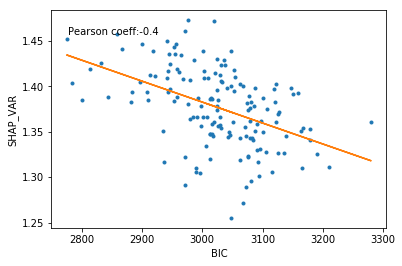

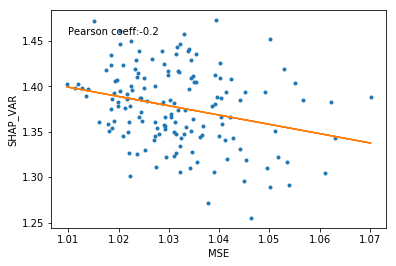

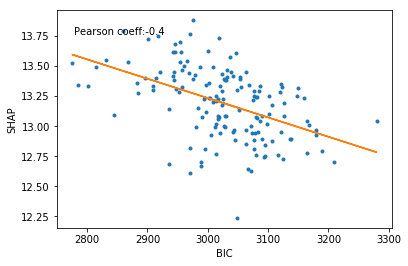

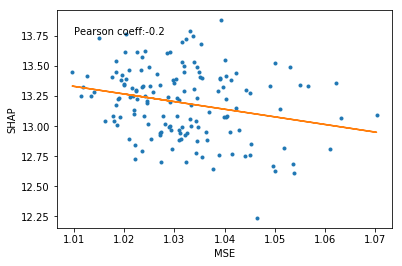

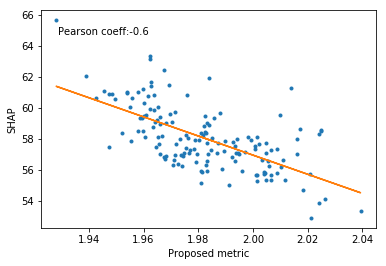

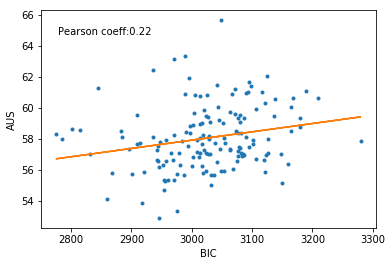

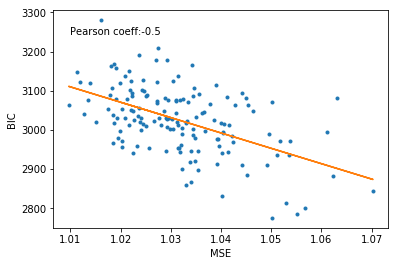

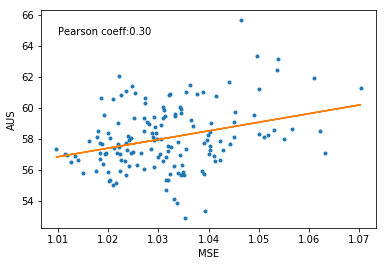

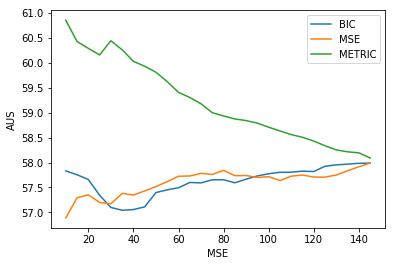

-0.6410206764255609

In [7]:
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text

fig, ax = plt.subplots()
b,m = polyfit(VIO,SHAP_VAR, 1)
#ax.plot(VIO,AUS, '.')

ax.plot(VIO,SHAP_VAR, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,SHAP_VAR)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
ax.set_xlabel("BIC")
ax.set_ylabel("SHAP_VAR")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,SHAP_VAR, 1)
#ax.plot(VIO,AUS, '.')

ax.plot(MSE,SHAP_VAR, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,SHAP_VAR)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(MSE, b + m * np.array(MSE), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("SHAP_VAR")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(VIO,SHAP, 1)
#ax.plot(VIO,AUS, '.')

ax.plot(VIO,SHAP, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,SHAP)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
ax.set_xlabel("BIC")
ax.set_ylabel("SHAP")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()



fig, ax = plt.subplots()
b,m = polyfit(MSE,SHAP, 1)
ax.plot(MSE,SHAP, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,SHAP)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(MSE, b + m * np.array(MSE), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("SHAP")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()


METRIC = (SHAP/np.max(SHAP)) + np.array(MSE)
fig, ax = plt.subplots()
b,m = polyfit(METRIC,AUS, 1)
ax.plot(METRIC,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(METRIC,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Proposed metric")
ax.set_ylabel("SHAP")
fig.savefig('Ex4ProposedVsAUS.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(VIO,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(VIO,AUS, '.')
plt.plot(VIO, b + m * np.array(VIO), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("BIC")
ax.set_ylabel("AUS")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,VIO, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,VIO)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,VIO, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSE")
ax.set_ylabel("BIC")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,AUS, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


MSE = np.array(MSE)

x = []
y1 = []
y2 = []
y3 = []
for split in range(10, len(AUS), 5):
    #print("******", split, "*******")
    sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(VIO,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]

    x.append(split)
    
    
    #print("Low Violations = ", np.mean(low), "for", len(low))
    #print("High Violations = ", np.mean(high), "for", len(high))
    y1.append(np.mean(low))
    sorted_aus_by_mse = [AUS for _,AUS in sorted(zip(MSE,AUS))]
    low = sorted_aus_by_mse[:split]
    high = sorted_aus_by_mse[split:]
    #print("Low AUS by MSE = ", np.mean(low), "for", len(low))
    #print("High AUS by MSE = ", np.mean(high), "for", len(high))
    y2.append(np.mean(low))
    sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(METRIC,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]



    #print("Low Metric = ", np.mean(low), "for", len(low))
    #print("High Metric = ", np.mean(high), "for", len(high))
    y3.append(np.mean(low))
    

fig, ax = plt.subplots()

ax.plot(x,y1, '-', label = 'BIC')
ax.plot(x,y2, '-', label = 'MSE')
ax.plot(x,y3, '-', label = 'METRIC')
ax.legend()

ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
plt.show()  
pearsonr(METRIC,AUS)[0]

In [8]:
def norm(a):
    return (a - np.min(a)) / a.ptp()
METRIC = norm(np.array(VIO)) + norm(np.array(MSE))
n_low = int(len(models) * 0.2)

sorted_aus = [SHAP_VAR for _,SHAP_VAR in sorted(zip(VIO,SHAP_VAR))]
print("SHAP VAR Best by BIC = ", np.mean(sorted_aus[:n_low]))

sorted_aus = [SHAP_VAR for _,SHAP_VAR in sorted(zip(MSE,SHAP_VAR))]
print("SHAP VAR Best by MSE = ", np.mean(sorted_aus[:n_low]))


sorted_aus = [SHAP_VAR for _,SHAP_VAR in sorted(zip(METRIC,SHAP_VAR))]
print("SHAP VAR Best by MET = ", np.mean(sorted_aus[:n_low]))
print("SHAP VAR Random = ", np.mean(SHAP_VAR[:n_low]))

sorted_aus = [SHAP for _,SHAP in sorted(zip(VIO,SHAP))]
print("SHAP Best by BIC = ", np.mean(sorted_aus[:n_low]))

sorted_aus = [SHAP for _,SHAP in sorted(zip(MSE,SHAP))]
print("SHAP Best by MSE = ", np.mean(sorted_aus[:n_low]))


sorted_aus = [SHAP for _,SHAP in sorted(zip(METRIC,SHAP))]
print("SHAP Best by MET = ", np.mean(sorted_aus[:n_low]))
print("SHAP Random = ", np.mean(SHAP[:n_low]))

sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
print("AUS Best by BIC = ", np.mean(sorted_aus[:n_low]))

sorted_aus = [AUS for _,AUS in sorted(zip(MSE,AUS))]
print("AUS Best by MSE = ", np.mean(sorted_aus[:n_low]))


sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
print("AUS Best by MET = ", np.mean(sorted_aus[:n_low]))
print("AUS Random = ", np.mean(AUS[:n_low]))

SHAP VAR Best by BIC =  1.4115172354776135
SHAP VAR Best by MSE =  1.3956991211976983
SHAP VAR Best by MET =  1.4213004407605851
SHAP VAR Random =  1.3896968614996263
SHAP Best by BIC =  13.435905296611706
SHAP Best by MSE =  13.314831024288258
SHAP Best by MET =  13.490942932175619
SHAP Random =  13.279160791534373
AUS Best by BIC =  57.09909003026239
AUS Best by MSE =  57.17196109572418
AUS Best by MET =  56.608105907187245
AUS Random =  57.57378560115041


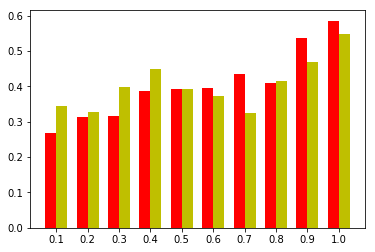

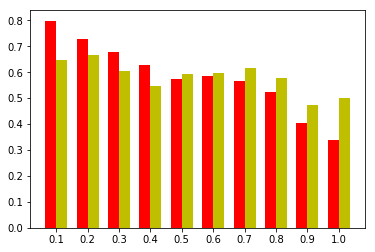

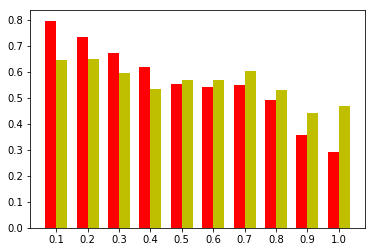

In [9]:
def plot_comparison(x1, x2, y,  bins = 10):
    sorted_y_by_x1 = [y for _,y in sorted(zip(x1,y))]
    sorted_y_by_x2 = [y for _,y in sorted(zip(x2,y))]
    total_len = len(sorted_y_by_x1)
    X = []
    Y1 = []
    Y2 = []
    for i in range(1, bins + 1):
        X.append(i / bins)
        Y1.append(np.mean(sorted_y_by_x1[int((i - 1)*(total_len/bins)):int(i*(total_len/bins))]))
        Y2.append(np.mean(sorted_y_by_x2[int((i - 1)*(total_len/bins)):int(i*(total_len/bins))]))
       
    fig, ax = plt.subplots()

    ind = np.arange(bins)    # the x locations for the groups
    width = 0.35         # the width of the bars
    p1 = ax.bar(ind, Y1, width, color='r',)

    p2 = ax.bar(ind + width, Y2, width,
                color='y' )

    #ax.set_title('Scores by group and gender')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(X)

    #ax.legend((p1[0], p2[0]), ('Men', 'Women'))
    #ax.yaxis.set_units(inch)
    ax.autoscale_view()

    plt.show()

def normalize(a):
    return (a - np.min(a)) / (np.max(a) - np.min(a))
plot_comparison(METRIC, MSE, normalize(AUS))
plot_comparison(METRIC, MSE, normalize(SHAP))
plot_comparison(METRIC, MSE, normalize(SHAP_VAR))
#plot_comparison(MSE, normalize(AUS))

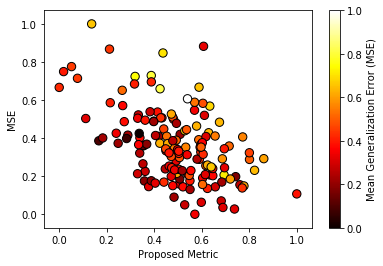

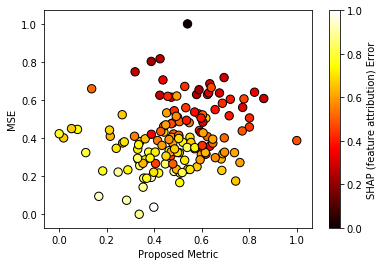

In [10]:
def heat_plot(x,y,z, xlab = 'Mean', ylab = 'Variance', zlab= 'Mean Generalization Error (MSE)', file = 'heat.pdf', clim_low = 0, clim_high = 1):
    fig, ax = plt.subplots()

    cax = ax.scatter(x, y, c=z, s=70, edgecolor='black', cmap = 'hot')
    cax.set_clim(clim_low, clim_high)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    #plt.colorbar(cax)
    cbar = plt.colorbar(cax)
    cbar.set_label(zlab)
    plt.show()
    fig.savefig(file, bbox = 'tight')
    
heat_plot(normalize(VIO), normalize(MSE), normalize(AUS), xlab = 'Proposed Metric', ylab = 'MSE', file = 'METRICvsMSE_Generalization.pdf')


heat_plot(normalize(VIO), normalize(AUS), normalize(SHAP), xlab = 'Proposed Metric', ylab = 'MSE', zlab = 'SHAP (feature attribution) Error' ,file = 'METRICvsMSE_SHAP.pdf')

1 1


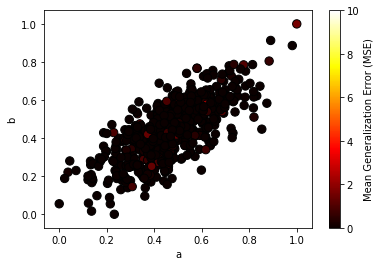

1 2


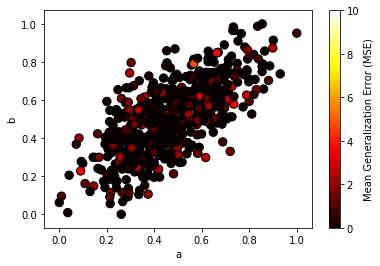

1 3


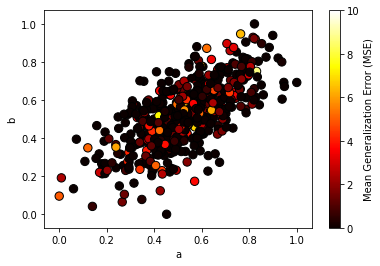

3 1


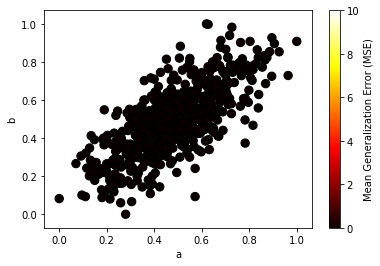

3 2


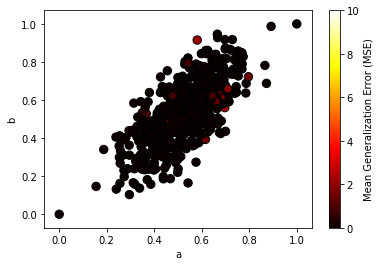

3 3


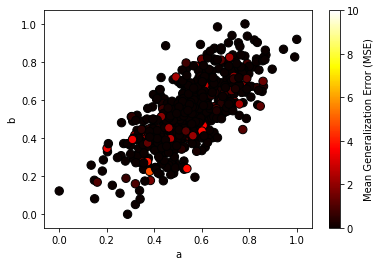

5 1


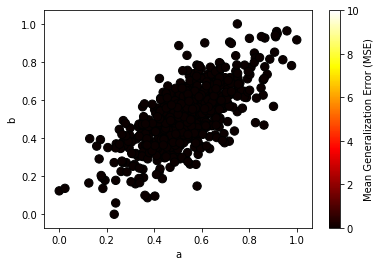

5 2


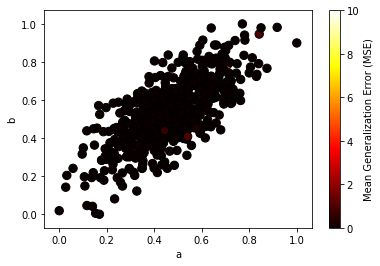

5 3


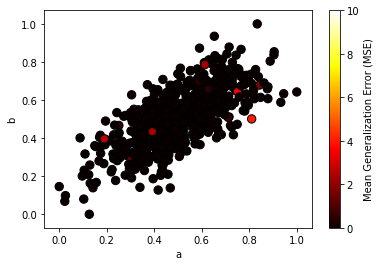

7 1


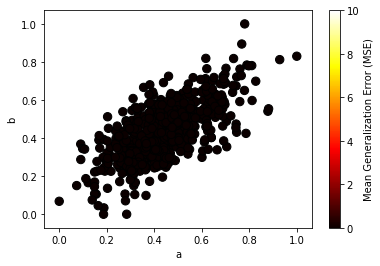

7 2


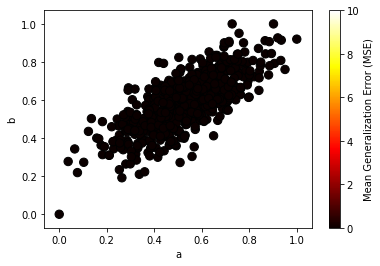

7 3


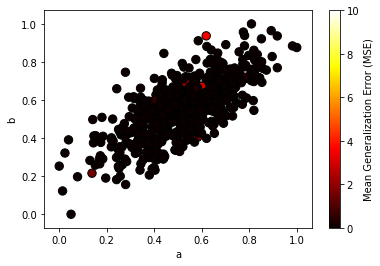

9 1


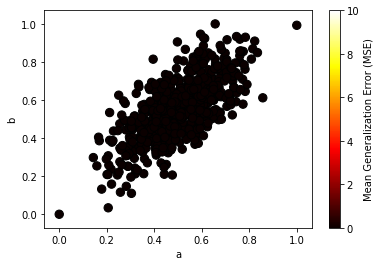

9 2


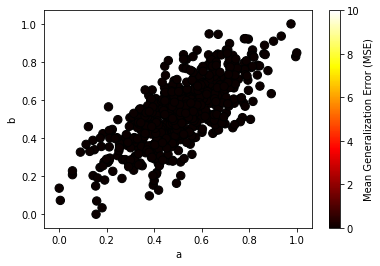

9 3


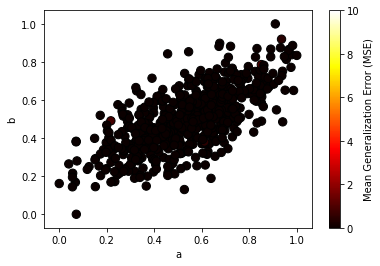

In [11]:
for m in range(1,10, 2):
    for v in range(1,4):
        print(m,v)
        df = gen_data(SIZE = 600, mean = m, var = v)
        heat_plot(normalize(df['a'].values), normalize(df['b'].values), np.squeeze(model.predict(df[['a', 'b']].values)) - df['c'].values,clim_high = 10, xlab = 'a', ylab = 'b', )